# Minkowski distance metrics explained

If you had to invent a machine learning algorithm from scratch, what would be some of the ways you'd find patterns in your data? One idea that you might have come up with is to assume that data points that are "close" to each other are similar, and those that are "distant" are dissimilar. You would not be alone in this thinking: some of the most important models and metrics in machine learning rely on finding the distances between data points, including [k-nearest neighbours classification](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm), [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) and loss functions such as [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error).

The question then comes: how do we define what we mean by close or distant? The first thing we need to understand is that all of our data points sit inside of what is called a [vector space](https://en.wikipedia.org/wiki/Vector_space). Don't be deterred by the terminology! Once we break it down and explain it you'll see this is quite simple to understand.

For this blog post, we're going to use the popular [dry bean dataset](https://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset#), which describes the characteristics of 13,611 images of dried beans across 7 different types. There are 16 features describing the beans, such as their area, aspect ratio and roundness.

In [2]:
import numpy as np
import pandas as pd

beans = pd.read_excel("data/Dry_Bean_Dataset.xlsx")

## Vector spaces

The easiest way to understand vector spaces is to start in two dimensions. Let's say we take two of our features: major and minor axis length, which are just the length and width of the bean respectively. If we plot a small number of our observations using these features, we can see that beans of the same type tend to be close to each other, and beans that are of different types tend to be far apart.

This is a 2-dimensional vector space, with each of our two features representing the x- and y-axes respectively, and the distance of data points (in this case, beans) to each other in this vector space is an indication of their similarity. Each bean in this dataset has a coordinate in this vector space represented by their values of the features. For example, the coordinate of the Bombay bean in this vector space below is $(653.68, 392.26)$.

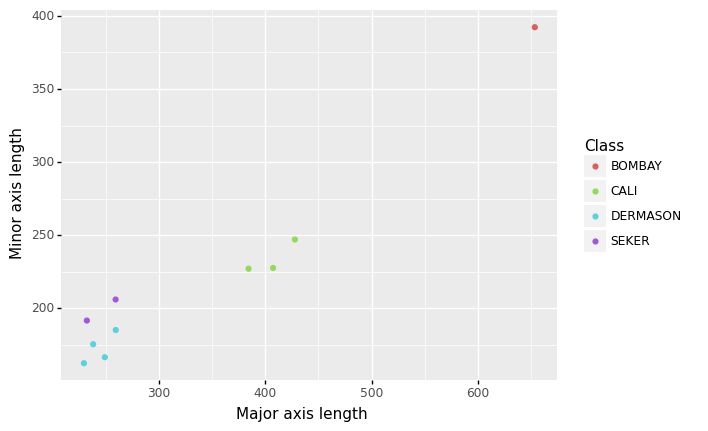

<ggplot: (8781372059405)>

In [106]:
from plotnine import *
from plotnine import ggplot

(
    ggplot(beans.sample(n = 10, random_state = 6)[["MajorAxisLength", "MinorAxisLength", "Class"]],
           aes("MajorAxisLength", "MinorAxisLength", colour = "Class"))
    + geom_point()
    + xlab("Major axis length")
    + ylab("Minor axis length")
)

We can extend this idea by seeing what happens if we plot the data against a third feature, `roundness`.

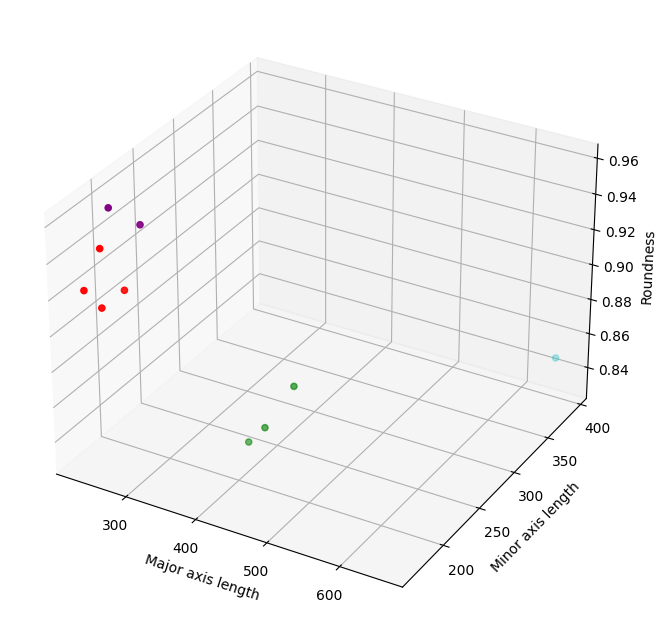

In [126]:
import matplotlib.pyplot as plt

beans_sample = beans.sample(n = 10, random_state = 6)[["MajorAxisLength", "MinorAxisLength", "roundness", "Class"]]
col=beans_sample['Class'].map({'DERMASON':'r','CALI':'g','BOMBAY':'c', "SEKER": "purple"})

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection = "3d")
ax.set_xlabel("Major axis length")
ax.set_ylabel("Minor axis length")
ax.set_zlabel("Roundness")

ax.scatter(beans_sample["MajorAxisLength"], beans_sample["MinorAxisLength"], beans_sample["roundness"], c = col)

You've probably already guessed that this graph is visualising a 3-dimensional vector space. As with the 2-dimensional vector space, the three features form the x-, y- and z-axes of this feature space, and the coordinates of the beans in this space are represented by their values of each of the features. In this larger feature space, the coordinate of the Bombay bean is now $(653.68, 392.26, 0.85)$. You can also see that, as with the 2-dimensional vector space, the distance between the points indicates their similarity, with beans that are of the same type grouping together, and those that are of different types falling far apart. We can keep extending this idea logically up to as many dimensions as we have features, but past the point of 3-dimensions we can no longer visualise it.

## The Minkowski distance metrics
The question that has likely been on your mind during the previous section is: well, _how_ do we actually measure these distances? It turns out there are quite a lot of different metrics, but today we'll be discussing two of the most commonly used, the [Manhattan](https://en.wikipedia.org/wiki/Taxicab_geometry) and [Euclidean](https://en.wikipedia.org/wiki/Euclidean_distance) distances.

In 2-dimensional vector spaces, these distance metrics are very intuitive to understand. For the Manhattan distance, imagine that you were forced to only travel in the direction of the x- and y-axes. In the example below, we have a point at $(2, 1)$ and another at $(4, 3)$. In order to travel from $(2, 1)$ to $(4, 3)$ using the Manhattan distance, we would need to first travel 2 units along the x-axis, and then another 2 units along the y-axis, giving us a total Manhattan distance of 4.

![](figures/manhattan_distance.png)

The Euclidean distance, by contrast, takes the "direct" path from one point to another. If you look at the diagram below, you can see that the path travelled for the Euclidean distance and the paths travelled for the Manhattan distance form a triangle, with the Euclidean distance as the hypotenuse.

![](figures/euclidean_distance.png)

This gives us a clue as to how to calculate the Euclidean distance: we can use the [Pythagorean theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem), treating the Euclidean distance path as our hypotenuse and the Manhattan distance path as our other two triangle sides. If we do this below, we get:

In [65]:
def calculate_hypotenuse(a: float,
                         b: float) -> float:
    """Given the two shorter triangle sides, uses the Pythagorean theorem to calculate the length of the hypotenuse."""
    c_sq = a**2 + b**2
    return np.sqrt(c_sq)

calculate_hypotenuse(2, 2)

2.8284271247461903

And voilà, the Euclidean distance between the points is 2.83.

As with vector spaces, we can generalise the Manhattan and Euclidean distances to whatever number of dimensions we want. But this method we've used above of calculating distances is very clunky, and it would be better to have a formula. Luckily, we not only have a formula, but it is the _same_ formula for both distance metrics: the [Minkowski distance metric](https://en.wikipedia.org/wiki/Minkowski_distance), shown below:

$$
D(X, Y) = \left(\sum_{i=1}^{n-1} | x_i - y_i |^p \right)^\frac{1}{p}
$$

Let's break this down. The first thing we need to do before we dive into the formula is start thinking of the coordinates of our points, e.g., $(2, 1)$, as _vectors_. These are essentially an ordered list that gives the position of a point in n-dimensions, with the number of elements of the vector corresponding to the number of dimensions. We've seen this already with our explanation of 2- and 3-dimensional vector spaces, where the coordinates of the 2-dimensional space represented the bean's value for each of the major and minor axes, and in the 3-dimensional space, the bean's value for each of the major and minor axes and the roundness. For our purposes, vectors and coordinates are interchangeable.

The Minkowski distance formula is first telling us that we have a pair of vectors, $X$ and $Y$, and we want to find the distance $D$ between them. Each vector has $i$ elements, so for a pair of vectors in a 4-dimensional vector space, we would have 4 elements in each. We then pair up the corresponding elements in each vector, take the absolute difference of each, and then raise that to the power of a number, $p$ (we'll come back to this value). Finally, we sum all of these differences, and then raise this sum to the power of $\frac{1}{p}$.

To make this really concrete, let's work through an example. We need a few different values for this:
* The vectors $X$ and $Y$
* The value of $i$
* The value of $p$.

Before we get to the example, let's talk about $p$. This is the value that allows us to switch between calculating the Manhattan and Euclidean distances, with $p = 1$ giving us the Manhattan distance and $p = 2$ giving us the Euclidean distance. We'll have a look at how this works as we go through the example. Let's get started.

In [68]:
X = [5, 7, 3, 9]
Y = [1, 6, 2, 4]
i = len(X)
p = 1

diff_1 = np.abs(X[0] - Y[0])
diff_2 = np.abs(X[1] - Y[1])
diff_3 = np.abs(X[2] - Y[2])
diff_4 = np.abs(X[3] - Y[3])

We have two vectors here, $X = (5, 7, 3, 9)$ and $Y = (1, 6, 2, 4)$, which we've represented using Python lists. As they have 4 elements each, they are in a 4-dimensional vector space and therefore $i = 4$. We then take the absolute difference of each paired element in these vectors. However, let's see what happens when we try to raise one of these differences to $p$ when $p = 1$.

In [69]:
diff_1

4

In [70]:
diff_1**p

4

It's the same value! This is because any value raised to the power of 1 returns the same value, so if we raised each of our absolute differences to 1, they would remain unchanged. We'll therefore leave out this step and proceed straight to adding all of these differences.

In [72]:
manhattan_distance = diff_1 + diff_2 + diff_3 + diff_4
manhattan_distance

11

You can see we've also left off the final step of raising this sum of differences to $\frac{1}{p}$. This is because $\frac{1}{1} = 1$, so again, we have no need to apply this step. Therefore, we have arrived at a final Manhattan distance of 11.

I hope you can see the parallels with what we did in our initial example on the Manhattan distance in a 2-dimensional vector space. What we've just done is travelled the distance along the x-axis, y-axis, z-axis and the fourth w-axis between the two points, and then simply added them together. Nothing more fancy than that.

Let's now work through our example using $p = 2$ for the Euclidean distance.

In [73]:
X = [5, 7, 3, 9]
Y = [1, 6, 2, 4]
i = len(X)
p = 2

diff_1 = np.abs(X[0] - Y[0])**p
diff_2 = np.abs(X[1] - Y[1])**p
diff_3 = np.abs(X[2] - Y[2])**p
diff_4 = np.abs(X[3] - Y[3])**p

euclidean_distance_sq = diff_1 + diff_2 + diff_3 + diff_4
euclidean_distance = euclidean_distance_sq**(1/p)
euclidean_distance

6.557438524302

You can see here that we've taken the differences between each paired element, taken their absolute value, and then squared them. We've then added them together to get the _squared_ Euclidean distance, and then finally raised them to the power of $\frac{1}{2}$ (in other words, taken the square root) to get the final Euclidean distance. Again, you can see the parallels with our first example of calculating the Euclidean distance. In that example, we used the Pythagorean theorem, but we are essentially doing the same thing here: getting the sides of a 4-dimensional triangle by taking the elementwise difference between the vectors, squaring them, adding them and then taking the square root.

We can double-check our results by using `sklearn`'s `DistanceMetric` method.

In [77]:
from sklearn.neighbors import DistanceMetric

manhattan = DistanceMetric.get_metric("manhattan")
manhattan.pairwise([X, Y])

/Users/jodie.burchell/.conda/envs/vectorising-python/lib/python3.9/site-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3


array([[ 0., 11.],
       [11.,  0.]])

In [128]:
euclidean = DistanceMetric.get_metric("euclidean")
euclidean.pairwise([X, Y])

/Users/jodie.burchell/.conda/envs/vectorising-python/lib/python3.9/site-packages/sklearn/neighbors/_distance_metric.py:10: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3


array([[0.        , 6.55743852],
       [6.55743852, 0.        ]])

As you can see, we've arrived at the exact same result by hand as `sklearn` does under the hood.

To finish, let's apply what we've learnt to our original sample of data from the dry beans dataset. From our visualisations, we would expect that beans that belong to the same type would have lower distances to each other than beans from different types. Let's assess this using the three features we visualised: `MajorAxisLength`, `MinorAxisLength` and `roundness`. We'll take two example beans from `DERMASON` and two from `CALI` and compare their distances.

In [83]:
dermason = (
    beans_sample[beans_sample["Class"] == "DERMASON"]
        .drop(columns = ["Class"])
        .sample(n = 2)
        .to_numpy()
)

cali = (
    beans_sample[beans_sample["Class"] == "CALI"]
        .drop(columns = ["Class"])
        .sample(n = 2)
        .to_numpy()
)

First, we calculate the pairwise Manhattan distances.

In [101]:
beans_manhattan = manhattan.pairwise(np.append(dermason, cali, axis = 0))
print(f"The Manhattan distance between the two dermason beans is: {beans_manhattan[0, 1]: .2f}")
print(f"The Manhattan distance between the two cali beans is: {beans_manhattan[3, 2]: .2f}")
print(f"The Manhattan distance between a dermason and a cali bean is: {beans_manhattan[0, 2]: .2f}")

The Manhattan distance between the two dermason beans is:  21.73
The Manhattan distance between the two cali beans is:  39.98
The Manhattan distance between a dermason and a cali bean is:  283.29


And then the Euclidean distances.

In [102]:
beans_euclidean = euclidean.pairwise(np.append(dermason, cali, axis = 0))
print(f"The Euclidean distance between the two dermason beans is: {beans_euclidean[0, 1]: .2f}")
print(f"The Euclidean distance between the two cali beans is: {beans_euclidean[3, 2]: .2f}")
print(f"The Euclidean distance between a dermason and a cali bean is: {beans_euclidean[0, 2]: .2f}")

The Euclidean distance between the two dermason beans is:  15.65
The Euclidean distance between the two cali beans is:  28.27
The Euclidean distance between a dermason and a cali bean is:  215.89


We can see that, as in the graph, the distances between beans of the same type is much smaller than those of different types, for both distance metrics.

That's it for this post: next time, we'll discuss how to implement the Minkowski distance formula in a function in a couple of different ways, with an eye to improving performance.




* Show picture of Manhattan distance, like walking a city block
* Show picture of Euclidean distance, talking the "direct path"
* Explain formula for Minkowski distance and break it down
* Show how this works for two points in 2D:
    * For Manhattan distance, we're travelling along the difference on the x-axis and then the distance on the y-axis
    * For Euclidean distance, imagine we treat those two x- and y-differences as sides of a triangle, then calculate the hypotenuse.

While, again, we can only really comfortably visualise this in 2- and 3D, the logic extends to n-dimensions as with vector spaces.

We now know what we need to calculate the Minowski difference, so let's create a simple implementation using loops.

Calculation of Minkowski distance:

Explain what this is in 2-d space:
* Manhattan
* Euclidean

Then show calculation of this using loops

Then work out which linear algebra functions you use to create the optimisation and explain them
Then show LA optimisation + timing for various n-dimensions and datasets
Comparing timing to sklearn implementation

In [50]:
np.sqrt((1-2)**2 + (4-3)**2)

1.4142135623730951

In [62]:
def minkowski_distance(a, b, p=1):

    # Store the number of dimensions
    dim = len(a)

    # Set initial distance to 0
    distance = 0

    # Calculate minkowski distance using parameter p
    for d in range(dim):
        distance += abs(a[d] - b[d])**p

    distance = distance**(1/p)

    return distance

In [67]:
minkowski_distance([2, 1], [4, 3], 1)

4.0

In [66]:
minkowski_distance([2, 1], [4, 3], 2)

2.8284271247461903

In [74]:
minkowski_distance([5, 7, 3, 9], [1, 6, 2, 4], 1)

11.0

In [75]:
minkowski_distance([5, 7, 3, 9], [1, 6, 2, 4], 2)

6.557438524302